# Voice Recognition

Voice Recognition using Keras(tf backend), based on dataset: [thchs_30](http://www.openslr.org/18/)

As the format and processing skills to sound are fresh to the author, some of the preprocessing and pipe line code are from [this amazing repo](https://github.com/lucko515/speech-recognition-neural-network)

In [7]:
DATA="/data/data_thchs30/"

In [8]:
%ls {DATA}

data/


In [11]:
TRAIN=DATA+"train/"
TEST=DATA+"test/"
ALL=DATA+"data/"
%ls -l {TRAIN}|wc -l
%ls -l {TEST}|wc -l
%ls -l {ALL}|wc -l

ls: /data/data_thchs30/train/: No such file or directory
       0
ls: /data/data_thchs30/test/: No such file or directory
       0
     616


In [27]:
LM_PHONE=DATA+"lm_phone/"
LM_WORD=DATA+"lm_word/"

lm_phone_lex=open(LM_PHONE+"lexicon.txt").read().split()
lm_phone_gram=open(LM_PHONE+"phone.3gram.lm").read().split()
lm_word_lex=open(LM_WORD+"lexicon.txt").read().split()
lm_word_gram=open(LM_WORD+"word.3gram.lm").read().split()

In [154]:
# %pip install librosa
# %pip install soundfile

In [3]:
from importlib import reload
from IPython import display
from IPython.display import Audio
import librosa
import utils;reload(utils)
from utils import *

In [4]:
librosa()

TypeError: 'module' object is not callable

In [5]:
def play(url):return display.Audio(url)

In [12]:
%ls {ALL}|head

A11_0.wav*
A11_0.wav.trn
A11_1.wav*
A11_1.wav.trn
A11_10.wav*
A11_10.wav.trn
A11_100.wav*
A11_100.wav.trn
A11_101.wav*
A11_101.wav.trn


In [14]:
%ls {ALL}|head

A11_0.wav*
A11_0.wav.trn
A11_1.wav*
A11_1.wav.trn
A11_10.wav*
A11_10.wav.trn
A11_100.wav*
A11_100.wav.trn
A11_101.wav*
A11_101.wav.trn


In [13]:
play(ALL+"A11_0.wav")

In [15]:
play(DATA+"data/A11_0.wav")

In [16]:
%cat {ALL+"A11_0.wav.trn"}

绿 是 阳春 烟 景 大块 文章 的 底色 四月 的 林 峦 更是 绿 得 鲜活 秀媚 诗意 盎然
lv4 shi4 yang2 chun1 yan1 jing3 da4 kuai4 wen2 zhang1 de5 di3 se4 si4 yue4 de5 lin2 luan2 geng4 shi4 lv4 de5 xian1 huo2 xiu4 mei4 shi1 yi4 ang4 ran2
l v4 sh ix4 ii iang2 ch un1 ii ian1 j ing3 d a4 k uai4 uu un2 zh ang1 d e5 d i3 s e4 s iy4 vv ve4 d e5 l in2 l uan2 g eng4 sh ix4 l v4 d e5 x ian1 h uo2 x iu4 m ei4 sh ix1 ii i4 aa ang4 r an2


## Data Processing

In [523]:
from glob import glob
from multiprocessing import Pool
from keras.preprocessing.sequence import pad_sequences
import scipy.io.wavfile as wav
from python_speech_features import mfcc

def process_url(url):
    ar,sr=librosa.load(url,sr=None)
    spec,freq=spectrogram(ar)
    return ar,sr,spec,freq

def calc_feat_dim(window, max_freq):
    return int(0.001 * window * max_freq) + 1

class audio_dataset:
    def __init__(self, glob_lbl,
                 glob_aud,
                 filepath,
                 shuffle=True,
                 batch_size=256,
                 step=10,
                 window=20,
                 max_freq=8000,
                mfcc_dim=13,
                 lbl_apd=".trn",
                 txt_max={"CN":30,"PY":30,"PH":60},
                 lang_use={"CN":True,"PY":False,"PH":True},
                 x_use={"spec":True,"mfcc":False},
                 train_perc=.95,
                 proc_n=6,
                ):
        self.filepath=filepath
        self.lbl_apd=lbl_apd
        self.glob_lbl=glob_lbl
        self.glob_aud=glob_aud
        self.lang=["CN","PY","PH"] # in this case, lang means language, like Chinese, Pinyin & Phonetic marks
        self.lang_use=lang_use
        self.x_use=x_use
        
        self.window=window
        self.step=step
        self.max_freq=max_freq
        self.txt_max=txt_max
        self.shuffle=shuffle
        self.batch_size=batch_size
        self.train_perc=train_perc
        self.index_train=0
        self.index_train=0
        
        self.mfcc_dim=mfcc_dim
        self.feat_dim = calc_feat_dim(window,max_freq)
        self.feats_mean = np.zeros((self.feat_dim,))
        self.feats_std = np.ones((self.feat_dim,))
        
        # vectorize filenames to text function
        self.f2t_cn=np.vectorize(self.fname2txt_cn)
        self.f2t_py=np.vectorize(self.fname2txt_py)
        self.f2t_ph=np.vectorize(self.fname2txt_ph)
        
        # vectorize word tokenzing function
        self.tok_cn=np.vectorize(self.tokenize_wd_cn)
        self.tok_py=np.vectorize(self.tokenize_wd_py)
        self.tok_ph=np.vectorize(self.tokenize_wd_ph)
        
        self.spectrogram = spectrogram
        self.mfcc = mfcc
        
#         if self.spectrogram*self.mfcc:
#             self.x_pipe=[self.to_array_spec,self.to_array_mfcc]
#         elif self.spectrogram:
#             self.x_pipe=[self.to_array_spec,]
#         elif self.mfcc:
#             self.x_pipe=[self.to_array_mfcc,]
#         else:
#             Print("Error:spectrogram and mfcc can not all be False")
            
        self.x_pipe = list(getattr(self,"to_array_%s"%f.lower()) for f,use in self.x_use.items() if use)
        self.y_pipe = list(getattr(self,"next_lbl_%s"%f.lower()) for f,use in self.lang_use.items() if use)
        
        self.get_lbl()
        self.get_audio()
        self.train_test_split()
        
        self.set_spec()
        self.set_mfcc()
        
        self.proc_n=proc_n
        self.p=Pool(self.proc_n)
#         self.process_urls()
        
    def get_lbl(self):
        self.lbl_urls=glob(self.glob_lbl)
        self.lbl_names=list(v.split("/")[-1] for v in self.lbl_urls)
        self.lbl_str=list(open(v).read().split("\n") for v in self.lbl_urls)
        
        self.lbl_size=len(self.lbl_str)
        print("Label Size",self.lbl_size)
        
        self.lbl_process()
        self.get_vocab()
        
    def train_test_split(self):
        # select index
        self.select=np.random.rand(len(self.aud_urls))>self.train_perc
        # train/test slicing
        self.aud_urls_train=np.array(self.aud_urls)[~self.select]
        self.aud_urls_test=np.array(self.aud_urls)[self.select]
        self.aud_names_train=np.array(self.aud_names)[~self.select]
        self.aud_names_test=np.array(self.aud_names)[self.select]
        print("Train/ Test split:\t%s/\t%s"%(len(self.aud_names_train),
                                             len(self.aud_names_test),)
                                            )
        
    def lbl_process(self):
        self.lbl,self.lbl_size=dict({}),dict({})
        for i in range(len(self.lang)):
            self.lbl[self.lang[i]]=dict((k,v[i]) for k,v in zip(self.lbl_names,self.lbl_str))
        
    def get_vocab(self):
        """
        Get the vocabulary table using the self.lbl text information
        """
        self.vocab,self.vocab_size,self.c2i,self.i2c=tuple(dict() for i in range(4))
        for i in range(len(self.lang)):
            # Vocabulary list for each language
            self.vocab[self.lang[i]]=list(set((" ".join(list(self.lbl[self.lang[i]].values()))).split(" ")))
            self.vocab_size[self.lang[i]]=len(self.vocab[self.lang[i]])
            
            # Character to index & Index to character mapping dictionary
            self.c2i[self.lang[i]]=dict((v,k) for k,v in enumerate(self.vocab[self.lang[i]]))
            self.i2c[self.lang[i]]=dict((k,v) for k,v in enumerate(self.vocab[self.lang[i]]))
            
            print(self.lang[i],"\tVocab Size","\t",self.vocab_size[self.lang[i]])
            
    def get_audio(self):
        self.aud_urls=glob(self.glob_aud)
        if self.shuffle:
            self.aud_urls=self.shuffle_(self.aud_urls)
        self.aud_names=list(i.split("/")[-1] for i in self.aud_urls)
    
    def shuffle_(self,urllist):
        return np.random.permutation(urllist).tolist()
    
    def process_urls(self,proc=6):
        p=Pool(proc)
        self.ar,self.sr,self.spec,self.freq=zip(list([ar,sr,spec,freq] for ar,sr,spec,freq in p.map(process_url,self.aud_urls)))
        
    def normalize(self,feature,eps=1e-14):
        """Cneter a feature using the mean and std"""
        return (feature-self.feats_mean)/(self.feats_std+eps)
    
    def normalize_mfcc(self,feature,eps=1e-14):
        """Cneter a feature using the mean and std"""
        return (feature-self.feats_mean_mfcc)/(self.feats_std_mfcc+eps)
    
    def to_array_spec(self,audio_clip):
        return self.normalize(self.featurize(audio_clip))
    
    def to_array_mfcc(self,audio_clip):
        return self.normalize_mfcc(self.featurize_mfcc(audio_clip))
    
    def featurize(self, audio_clip):
        """ For a given audio clip, calculate the corresponding feature
        Params:
            audio_clip (str): Path to the audio clip
        """
        return spectrogram_from_file(
                self.filepath + audio_clip, step=self.step, window=self.window,
                max_freq=self.max_freq)
    
    def featurize_mfcc(self, audio_clip):
        (rate, sig) = wav.read(self.filepath + audio_clip)
        return mfcc(sig, rate, numcep=self.mfcc_dim)
    
    def set_spec(self,):
        samples=np.random.choice(self.aud_names,100).tolist()
        feats=np.vstack(list(map(self.featurize,samples)))
        self.feats_mean=np.mean(feats, axis=0)
        self.feats_std=np.std(feats, axis=0)
        
    def set_mfcc(self,):
        samples=np.random.choice(self.aud_names,100).tolist()
        feats=np.vstack(list(map(self.featurize_mfcc,samples)))
        self.feats_mean_mfcc=np.mean(feats, axis=0)
        self.feats_std_mfcc=np.std(feats, axis=0)
    
    def txt2idx_cn(self,txt):
        try:
            return self.vocab["CN"][txt]
        except:
            return self.vocab_size["CN"]
        
    def txt2idx_ph(self,txt):
        try:
            return self.vocab["PH"][txt]
        except:
            return self.vocab_size["PH"]
        
    def txt2idx_py(self,txt):
        try:
            return self.vocab["PY"][txt]
        except:
            return self.vocab_size["PY"]
        
    def next_lbl(self,w_names):
        return tuple(yf(w_names) for yf in self.y_pipe)
        
    def next_lbl_cn(self,w_names):
        lines = self.f2t_cn(w_names)
        return np.array(pad_sequences(list(map(lambda x:self.tok_cn(x.split(" ")).tolist(),lines)),
                             #maxlen=self.txt_max["CN"],
                             value=self.vocab_size["CN"],
                            ))
    
    def next_lbl_py(self,w_names):
        lines = self.f2t_py(w_names)
        return np.array(pad_sequences(list(map(lambda x:self.tok_py(x.split(" ")).tolist(),lines)),
                             #maxlen=self.txt_max["PY"],
                             value=self.vocab_size["PY"],
                            ))
    
    def next_lbl_ph(self,w_names):
        lines = self.f2t_ph(w_names)
        return np.array(pad_sequences(list(map(lambda x:self.tok_ph(x.split(" ")).tolist(),lines)),
                             #maxlen=self.txt_max["PH"],
                             value=self.vocab_size["PH"],
                            ))
        
#     def fname2txt_cn(self,fname):return np.vectorize(lambda x:ad.c2i["CN"][x])(self.lbl["CN"][fname+self.lbl_apd].split(" "))
    def fname2txt_cn(self,fname):return self.lbl["CN"][fname+self.lbl_apd]
        
    def fname2txt_ph(self,fname):return self.lbl["PH"][fname+self.lbl_apd]
    
    def fname2txt_py(self,fname):return self.lbl["PY"][fname+self.lbl_apd]
    
    def tokenize_wd_cn(self,word):
        try:
            return self.c2i["CN"][word]
        except:
            return self.vocab_size["CN"]
        
    def tokenize_wd_py(self,word):
        try:
            return self.c2i["PY"][word]
        except:
            return self.vocab_size["PY"]
    
    def tokenize_wd_ph(self,word):
        try:
            return self.c2i["PH"][word]
        except:
            return self.vocab_size["PH"]
        
    def next_x(self,w_names):
        Xs = list(zip(*list(map(self.read_data,w_names))))
        Xs = tuple(np.array(pad_sequences(list(x),value=0.0)) for x in Xs)
        return Xs
        
    def read_data(self,w_name):
        return list(func(w_name) for func in self.x_pipe)
    
    def get_batch_train(self):
        w_names=self.aud_names_train[self.index_train:self.index_train+self.batch_size]
        return self.next_x(w_names)+self.next_lbl(w_names)
    
    def get_batch_test(self):
        w_names=self.aud_names_test[self.index_test:self.index_test+self.batch_size]
        return self.next_x(w_names)+self.next_lbl(w_names)
    
    def next_train(self):
        while True:
            ret = self.get_batch_train()
            self.index_train += self.batch_size
            if self.index_train >= len(self.aud_names_train) - self.batch_size:
                self.index_train = 0
#                 self.aud_names_train = self.shuffle_(self.aud_names_train)
            yield ret
    
    def next_test(self):
        while True:
            ret = self.get_batch_test()
            self.index_test += self.batch_size
            if self.index_test >= len(self.aud_names_test) - self.batch_size:
                self.index_test = 0
#                 self.aud_names_test = self.shuffle_(self.aud_names_test)
            yield ret
    # def get_batch_test(self):
        
    # The data generator
#     def get_batch(self, partition):
#         """ 
#         Obtain a batch of train, validation, or test data
#         """
#         if partition == 'train':
#             audio_paths = self.train_audio_paths
#             cur_index = self.cur_train_index
#             texts = self.train_texts
#         elif partition == 'valid':
#             audio_paths = self.valid_audio_paths
#             cur_index = self.cur_valid_index
#             texts = self.valid_texts
#         elif partition == 'test':
#             audio_paths = self.test_audio_paths
#             cur_index = self.test_valid_index
#             texts = self.test_texts
#         else:
#             raise Exception("Invalid partition. "
#                 "Must be train/validation")

#         features = [self.normalize(self.featurize(a)) for a in 
#             audio_paths[cur_index:cur_index+self.minibatch_size]]

#         # calculate necessary sizes
#         max_length = max([features[i].shape[0] 
#             for i in range(0, self.minibatch_size)])
#         max_string_length = max([len(texts[cur_index+i]) 
#             for i in range(0, self.minibatch_size)])
        
#         # initialize the arrays
#         X_data = np.zeros([self.minibatch_size, max_length, 
#             self.feat_dim*self.spectrogram + self.mfcc_dim*(not self.spectrogram)])
#         labels = np.ones([self.minibatch_size, max_string_length]) * 28
#         input_length = np.zeros([self.minibatch_size, 1])
#         label_length = np.zeros([self.minibatch_size, 1])
        
#         for i in range(0, self.minibatch_size):
#             # calculate X_data & input_length
#             feat = features[i]
#             input_length[i] = feat.shape[0]
#             X_data[i, :feat.shape[0], :] = feat

#             # calculate labels & label_length
#             label = np.array(text_to_int_sequence(texts[cur_index+i])) 
#             labels[i, :len(label)] = label
#             label_length[i] = len(label)
#          # return the arrays
#         outputs = {'ctc': np.zeros([self.minibatch_size])}
#         inputs = {'the_input': X_data, 
#                   'the_labels': labels, 
#                   'input_length': input_length, 
#                   'label_length': label_length 
#                  }
#         return (inputs, outputs)
        

In [524]:
ad=audio_dataset(DATA+"data/*.trn",
                 DATA+"data/*.wav",
                DATA+"data/",
                 x_use={"spec":True,"mfcc":False},
#                   mfcc=True,
                )

Label Size 3782
CN 	Vocab Size 	 3031
PY 	Vocab Size 	 960
PH 	Vocab Size 	 205
Train/ Test split:	3585/	197


In [520]:
g=ad.next_train()

In [521]:
a=g.__next__()

In [490]:
%time names=rd_names(256)

CPU times: user 810 µs, sys: 52 µs, total: 862 µs
Wall time: 923 µs


In [500]:
%time nxt=ad.next_x(names)
print(nxt[0].shape)

CPU times: user 2.86 s, sys: 1.39 s, total: 4.26 s
Wall time: 4.33 s
(256, 1474, 161)


In [487]:
type(a),len(a)

(tuple, 3)

In [452]:
type(a[0]),a[0].shape

(numpy.ndarray, (10, 1061, 13))

In [ ]:
type(a[1]),a[1].shape

In [434]:
type(a[0][0]),a[0][0].shape

(numpy.ndarray, (1025, 161))

# Spectrogram

### Visualize the Spectrogram

/Users/zhangxiaochen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['msyh'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


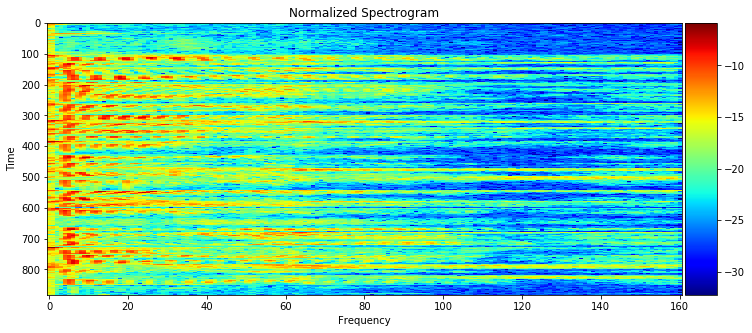

In [75]:
plot_spectrogram_feature(ad.normalize(ad.featurize(ad.aud_urls[1])))

# DNN Model

In [525]:
from keras.layers import *
from keras.models import *